In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import datetime
import seaborn as sns
import pickle
import gzip
import os
import matplotlib.pyplot as plt



from helpers import *

The aim of this notebook is to identify the channels that talk about a release event to analyze their evolution in terms of the number of subscribers compared to those that do not talk about the event. First, we focus on 1 event, the release of the iPhone x. Then, we will generalize to the 5 others. From the title and tags of the videos, we classify them according to the presence of the item "iPhone x" in this metadata : treat,if talks about the release, control if not. We focus on videos that have an upload date from the release till one month later.
Then, we classify the channels considering that if a channel has at least one video that talks about the release,then it is a treat channel. 
We compare the growth of channels (measured in terms of the number of subscribers) for treat and control channels to see if channels that talk about a release have a higher growth than the ones that do not. To do this comparison, we use the time series data and focus on a period that goes from 15 days before the release till 15 days after.
Then, we will do an observational study (causal analysis) with the outcome being the number of subscribers while identifying the potential confounders.
We first, focus on 1 event "iPhone x"

1. classify channels in the treat/control group,
2. causal observation (like lab 5) with outcome being the nb of subscribers one month after the event 

In [4]:
DIR = os.getcwd()

# raw data
RAW = "\data\\raw"
PATH_DF_CHANNELS = DIR + RAW + '\\df_channels_en.tsv.gz' # 6 mb
PATH_DF_TIMESERIES = DIR + RAW + '\\df_timeseries_en.tsv.gz' # 571 mb
PATH_YT_METADATA = DIR + RAW + '\\yt_metadata_en.jsonl.gz' # 13.6 gb
PATH_NUM_COMMENTS = DIR + RAW + '\\num_comments.tsv.gz' # 754 mb

# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

### Prepare the Dataset

In [10]:
ITEMS = [
    'iphone x',
    # 'iphone 7', 
    # 'iphone 6', 
    # 'galaxy s9', 
    # 'galaxy note 9', 
    # 'galaxy fold'
]
RELEASE_DATES = {
    'iphone x': pd.to_datetime('2017-11-03'),
    # 'iphone 7': '2016-09-16',
    # 'iphone 6': '2014-09-19',
    # 'galaxy s9': '2018-03-16',
    # 'galaxy note 9': '2018-08-24',
    # 'galaxy fold': '2019-02-01'
}

In [29]:
df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA, sep="\t", compression="infer")
df_tech_review_mt = df_tech_review_mt.drop('Unnamed: 0',axis=1)
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS, sep="\t", compression="infer")
df_tech_review_channels = df_tech_review_channels.drop('Unnamed: 0',axis=1)

In [38]:
df_video = df_tech_review_mt.copy()
df_channel = df_tech_review_channels.copy()

In [44]:
def find_in_name_and_tags(df,item):
  df = df[df.title.notna()]
  df["upload_date"] = pd.to_datetime(df["upload_date"])
  
  df.loc[
    (df["title"].str.lower().str.contains(item)) &
    (df["upload_date"] > RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=3)) & 
    (df["upload_date"] < RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=3))
    ,item] = 1 
  
  df[item].fillna(0,inplace=True)

  return df
  
df_video = find_in_name_and_tags(df_video,"iphone x")

In [46]:
df_video.groupby('iphone x')['display_id'].count()

iphone x
0.0    734281
1.0      5735
Name: display_id, dtype: int64

In [47]:
iphone_x_ch = df_video.groupby('channel_id',as_index=False)[['iphone x']].sum()
iphone_x_channels = pd.merge(df_channel,iphone_x_ch,on='channel_id',how='left')
iphone_x_channels

,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,iphone x
0,2010-12-21,UCsTcErHg8oDvUnTzoqsYeNw,Unbox Therapy,15300000,1672,206.0,2.0870,406.0,74.0
1,2015-10-19,UCOhHO2ICt0ti9KAh-QHvttQ,Technical Guruji,13979890,2539,240.0,2.0870,209.0,133.0
2,2012-05-18,UCe_vXdMrHHseZ_esYUskSBw,CrazyRussianHacker,11200000,1411,444.0,2.0870,105.0,1.0
3,2005-06-22,UCE_M8A5yxnLfW0KghEeajjw,Apple,9970000,291,489.0,2.0870,64.0,2.0
4,2008-03-21,UCBJycsmduvYEL83R_U4JriQ,Marques Brownlee,9400000,1148,530.0,2.0870,370.0,12.0
...,...,...,...,...,...,...,...,...,...
1245,2012-06-06,UCgMHqEDFll6X962CgXPzh4w,FocusCamera TV,10000,278,940963.0,40.6530,42.0,0.0
1246,2018-02-25,UCJjacdkHH7Zxw8ouKQrirUg,The Best Coders,10200,28,941074.0,42.4845,2.0,0.0
1247,2016-07-17,UCviAcL8AlEoGqLDWx7t_iPw,Mobile Tag,10300,20,952387.0,53.1435,6.0,0.0
1248,2011-02-20,UCncAHfjOv1B_U8esTmLYukQ,Curtis Paradis,10300,97,963290.0,53.1435,11.0,32.0


In [65]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# get the total number of views per channel
view_sum = df_tech_review_mt.groupby('channel_id',as_index=False)[['view_count']].sum().rename({'view_count':'view_sum'},axis=1)

# define dataframe for observational study
df_obs = pd.merge(iphone_x_channels,tech_df_avg,on='channel_id',how='left')
df_obs = pd.merge(df_obs,view_sum,on='channel_id',how='left')

# get the ratio of tech videos
df_obs['tech_videos_ratio'] = df_obs['count_tech_videos'] / df_obs['videos_cc']
df_obs = df_obs[['channel_id','subscribers_cc','iphone x','avg_duration','avg_delay','view_sum','tech_videos_ratio']]

In [86]:
# 0 - 10, 10 - 100, > 100
df_obs['treat'] = pd.cut(df_obs['iphone x'], [-1, 0, 10, 100, 1000], labels=['0', '1-10', '11-100', '>100'])
df_obs = pd.get_dummies(data=df_obs,columns=['treat'])
df_obs

C:\Users\jsayd\AppData\Local\Temp\ipykernel_15844\1890535493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['treat'] = pd.cut(df_obs['iphone x'], [-1, 0, 10, 100, 1000], labels=['0', '1-10', '11-100', '>100'])


,channel_id,subscribers_cc,iphone x,avg_duration,avg_delay,view_sum,tech_videos_ratio,treat_0,treat_1-10,treat_11-100,treat_>100
0,UCsTcErHg8oDvUnTzoqsYeNw,15300000,74.0,325.411332,2.109313,3.255926e+09,0.242823,0,0,1,0
1,UCOhHO2ICt0ti9KAh-QHvttQ,13979890,133.0,521.300635,0.639003,1.448510e+09,0.082316,0,0,0,1
2,UCe_vXdMrHHseZ_esYUskSBw,11200000,1.0,383.399260,2.056179,2.669755e+09,0.074415,0,1,0,0
3,UCE_M8A5yxnLfW0KghEeajjw,9970000,2.0,2160.136282,27.291717,6.218394e+08,0.219931,0,1,0,0
4,UCBJycsmduvYEL83R_U4JriQ,9400000,12.0,366.699845,8.567125,1.511520e+09,0.322300,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1245,UCgMHqEDFll6X962CgXPzh4w,10000,0.0,195.165584,23.951628,3.458270e+06,0.151079,1,0,0,0
1246,UCJjacdkHH7Zxw8ouKQrirUg,10200,0.0,269.364583,89.383333,1.904515e+06,0.071429,1,0,0,0
1247,UCviAcL8AlEoGqLDWx7t_iPw,10300,0.0,161.550000,32.016667,3.847000e+03,0.300000,1,0,0,0
1248,UCncAHfjOv1B_U8esTmLYukQ,10300,32.0,721.483849,21.920352,5.164490e+05,0.113402,0,0,1,0


### Matching

In [251]:
# 1st group
df_1 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_1-10'] == 1)].drop(['treat_0','treat_11-100','treat_>100'],axis=1).rename({'treat_1-10':'treat'},axis=1)
match = balance_data(df_1,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
df_1_matched = df_1.loc[match]

# 2nd group
df_2 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_11-100'] == 1)].drop(['treat_0','treat_1-10','treat_>100'],axis=1).rename({'treat_11-100':'treat'},axis=1)
match = balance_data(df_2,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
df_2_matched = df_2.loc[match]

# 3rd group
df_3 = df_obs[(df_obs['treat_0'] == 1) | (df_obs['treat_>100'] == 1)].drop(['treat_0','treat_1-10','treat_11-100'],axis=1).rename({'treat_>100':'treat'},axis=1)
match = balance_data(df_3,treat_column='treat',continuous_features=['subscribers_cc','avg_delay','tech_videos_ratio'])
df_3_matched = df_3.loc[match]

c:\Users\jsayd\Documents\Master_courses\ada\project\helpers.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - data[column].mean())/data[column].std()
c:\Users\jsayd\Documents\Master_courses\ada\project\helpers.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Propensity_score'] = res.predict()


Optimization terminated successfully.
         Current function value: 0.635625
         Iterations 6


c:\Users\jsayd\Documents\Master_courses\ada\project\helpers.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - data[column].mean())/data[column].std()
c:\Users\jsayd\Documents\Master_courses\ada\project\helpers.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Propensity_score'] = res.predict()


Optimization terminated successfully.
         Current function value: 0.364356
         Iterations 8


c:\Users\jsayd\Documents\Master_courses\ada\project\helpers.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = (data[column] - data[column].mean())/data[column].std()
c:\Users\jsayd\anaconda3\envs\ada\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\jsayd\Documents\Master_courses\ada\project\helpers.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Propensity_score'] = res.predict()


Optimization terminated successfully.
         Current function value: 0.018668
         Iterations 17


#### see the results of matching

# channel in group 1: 876
# channel in group 2: 258
# channel in group 3: 12


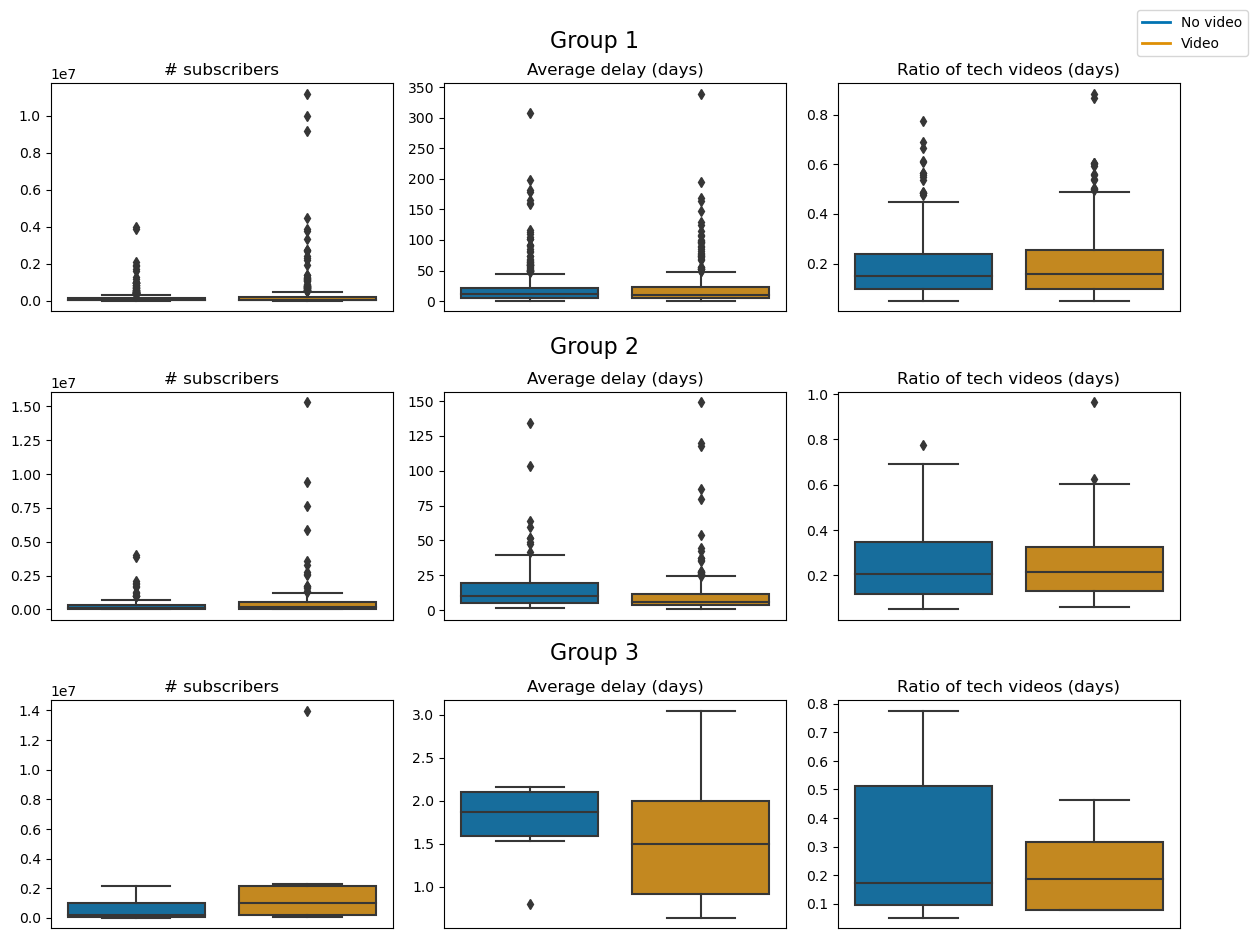

In [252]:
from matplotlib.lines import Line2D

print("# channel in group 1:",df_1_matched.shape[0])
print("# channel in group 2:",df_2_matched.shape[0])
print("# channel in group 3:",df_3_matched.shape[0])

# plot
colors = sns.color_palette("colorblind",2)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

# group 1
sns.boxplot(y=df_1_matched['subscribers_cc'],x=df_1_matched['treat'],ax=axes[0][0],palette=colors)
sns.boxplot(y=df_1_matched['avg_delay'],x=df_1_matched['treat'],ax=axes[0][1],palette=colors)
sns.boxplot(y=df_1_matched['tech_videos_ratio'],x=df_1_matched['treat'],ax=axes[0][2],palette=colors)

axes[0][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
axes[0][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[0][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])

fig.text(0.5, 1, 'Group 1', ha='center', fontsize=16)

# group 2
sns.boxplot(y=df_2_matched['subscribers_cc'],x=df_2_matched['treat'],ax=axes[1][0],palette=colors)
sns.boxplot(y=df_2_matched['avg_delay'],x=df_2_matched['treat'],ax=axes[1][1],palette=colors)
sns.boxplot(y=df_2_matched['tech_videos_ratio'],x=df_2_matched['treat'],ax=axes[1][2],palette=colors)

axes[1][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
axes[1][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[1][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])

fig.text(0.5, 0.66, 'Group 2', ha='center', fontsize=16)

# group 3
sns.boxplot(y=df_3_matched['subscribers_cc'],x=df_3_matched['treat'],ax=axes[2][0],palette=colors)
sns.boxplot(y=df_3_matched['avg_delay'],x=df_3_matched['treat'],ax=axes[2][1],palette=colors)
sns.boxplot(y=df_3_matched['tech_videos_ratio'],x=df_3_matched['treat'],ax=axes[2][2],palette=colors)

axes[2][0].set(title='# subscribers',xlabel=None,ylabel=None,xticks=[])
axes[2][1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[2][2].set(title='Ratio of tech videos (days)',xlabel=None,ylabel=None,xticks=[])

fig.text(0.5, 0.32, 'Group 3', ha='center', fontsize=16)


# Create custom legend handles with Line2D objects
legend_handles = [Line2D([0], [0], color=colors[0], lw=2),
                  Line2D([0], [0], color=colors[1], lw=2)]

# Use the custom handles in the legend
fig.legend(handles=legend_handles, labels=['No video', 'Video'], bbox_to_anchor=(1.05, 1.05))
plt.tight_layout(h_pad=4)
plt.show()

### Plots of observational analysis

#### Preparing the time series dataset

In [170]:
# Load the time series data.
time_series = pd.read_csv(PATH_DF_TIMESERIES, sep="\t", compression="infer")
time_series.datetime = pd.to_datetime(time_series.datetime)
time_series.rename({'channel':'channel_id'},axis=1,inplace=True)
time_series['ratio_subs'] = time_series['delta_subs'] / time_series['subs']
time_series['ratio_views'] = time_series['delta_views'] / time_series['views']
time_series_obs = time_series[['channel_id','datetime','ratio_subs','ratio_views','subs']]
time_series_obs['year_month'] = pd.to_datetime(time_series_obs.datetime.dt.strftime('%Y-%m'))

C:\Users\jsayd\AppData\Local\Temp\ipykernel_15844\3462721623.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_obs['year_month'] = pd.to_datetime(time_series_obs.datetime.dt.strftime('%Y-%m'))


In [171]:
# filtering the time series data: keep the ones with a datetime from 9 months before the release till 9 months after 
time_series_iphone_x = time_series_obs[
        (time_series_obs["datetime"] > RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=9)) & 
        (time_series_obs["datetime"] < RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=9))
    ]

#### Group 1

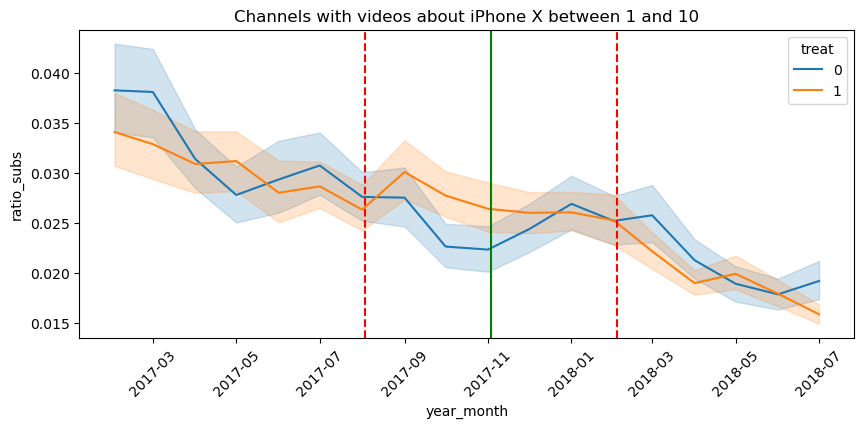

In [253]:
channels_1 = df_1_matched.channel_id.unique()
df_1_time_series = time_series_iphone_x[time_series_iphone_x.channel_id.isin(channels_1)]
df_1_time_series = pd.merge(df_1_time_series, df_1_matched[['channel_id','treat']], on='channel_id', how='left') 

plt.figure(figsize=(10,4))
sns.lineplot(data=df_1_time_series, x='year_month', y='ratio_subs', hue='treat')
plt.axvline(x=RELEASE_DATES[ITEMS[0]], color='green', linestyle='-')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=3), color='red', linestyle='--')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=3), color='red', linestyle='--')

plt.title('Channels with videos about iPhone X between 1 and 10')
plt.xticks(rotation=45)
plt.show()

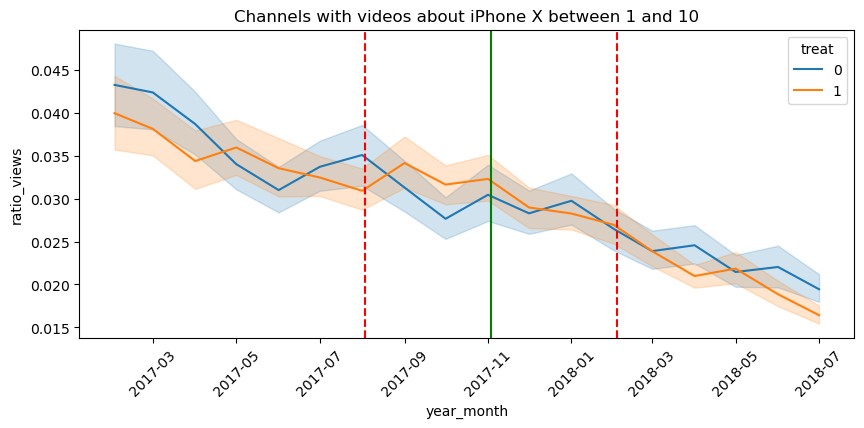

In [254]:
channels_1 = df_1_matched.channel_id.unique()
df_1_time_series = time_series_iphone_x[time_series_iphone_x.channel_id.isin(channels_1)]
df_1_time_series = pd.merge(df_1_time_series, df_1_matched[['channel_id','treat']], on='channel_id', how='left') 

plt.figure(figsize=(10,4))
sns.lineplot(data=df_1_time_series, x='year_month', y='ratio_views', hue='treat')
plt.axvline(x=RELEASE_DATES[ITEMS[0]], color='green', linestyle='-')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=3), color='red', linestyle='--')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=3), color='red', linestyle='--')

plt.title('Channels with videos about iPhone X between 1 and 10')
plt.xticks(rotation=45)
plt.show()

#### Group 2

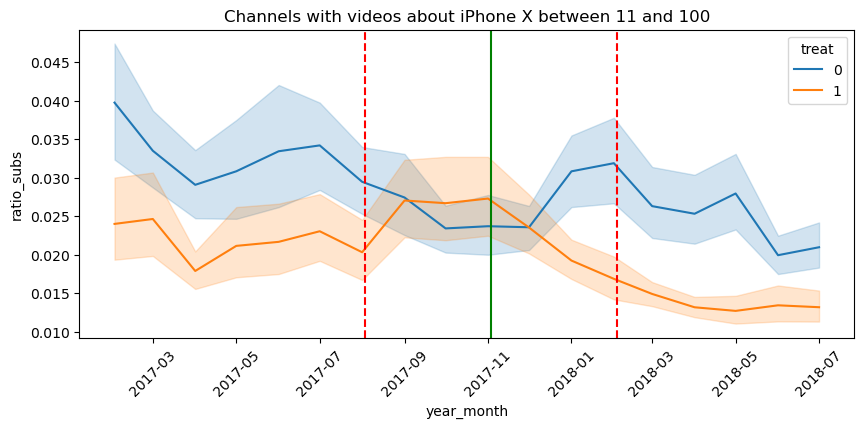

In [255]:
channels_2 = df_2_matched.channel_id.unique()
df_2_time_series = time_series_iphone_x[time_series_iphone_x.channel_id.isin(channels_2)]
df_2_time_series = pd.merge(df_2_time_series, df_2_matched[['channel_id','treat']], on='channel_id', how='left') 

plt.figure(figsize=(10,4))
sns.lineplot(data=df_2_time_series, x='year_month', y='ratio_subs', hue='treat')
plt.axvline(x=RELEASE_DATES[ITEMS[0]], color='green', linestyle='-')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=3), color='red', linestyle='--')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=3), color='red', linestyle='--')

plt.title('Channels with videos about iPhone X between 11 and 100')
plt.xticks(rotation=45)
plt.show()

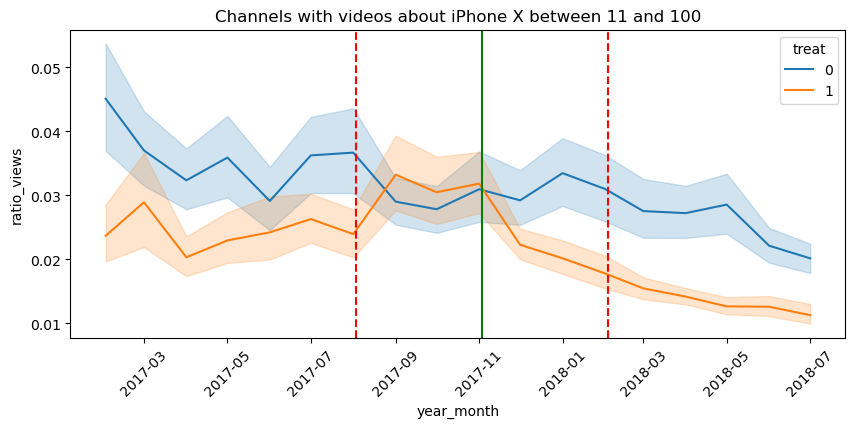

In [256]:
channels_2 = df_2_matched.channel_id.unique()
df_2_time_series = time_series_iphone_x[time_series_iphone_x.channel_id.isin(channels_2)]
df_2_time_series = pd.merge(df_2_time_series, df_2_matched[['channel_id','treat']], on='channel_id', how='left') 

plt.figure(figsize=(10,4))
sns.lineplot(data=df_2_time_series, x='year_month', y='ratio_views', hue='treat')
plt.axvline(x=RELEASE_DATES[ITEMS[0]], color='green', linestyle='-')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=3), color='red', linestyle='--')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=3), color='red', linestyle='--')

plt.title('Channels with videos about iPhone X between 11 and 100')
plt.xticks(rotation=45)
plt.show()

#### Group 3

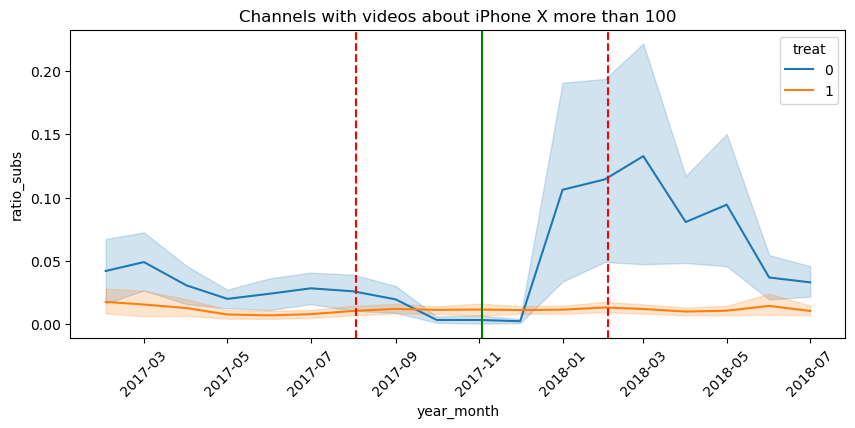

In [257]:
channels_3 = df_3_matched.channel_id.unique()
df_3_time_series = time_series_iphone_x[time_series_iphone_x.channel_id.isin(channels_3)]
df_3_time_series = pd.merge(df_3_time_series, df_3_matched[['channel_id','treat']], on='channel_id', how='left') 

plt.figure(figsize=(10,4))
sns.lineplot(data=df_3_time_series, x='year_month', y='ratio_subs', hue='treat')
plt.axvline(x=RELEASE_DATES[ITEMS[0]], color='green', linestyle='-')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=3), color='red', linestyle='--')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=3), color='red', linestyle='--')

plt.title('Channels with videos about iPhone X more than 100')
plt.xticks(rotation=45)
plt.show()

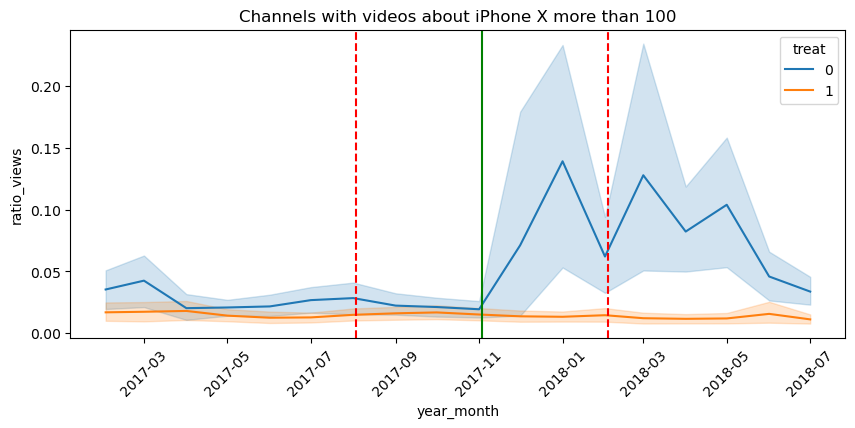

In [258]:
channels_3 = df_3_matched.channel_id.unique()
df_3_time_series = time_series_iphone_x[time_series_iphone_x.channel_id.isin(channels_3)]
df_3_time_series = pd.merge(df_3_time_series, df_3_matched[['channel_id','treat']], on='channel_id', how='left') 

plt.figure(figsize=(10,4))
sns.lineplot(data=df_3_time_series, x='year_month', y='ratio_views', hue='treat')
plt.axvline(x=RELEASE_DATES[ITEMS[0]], color='green', linestyle='-')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]-pd.DateOffset(months=3), color='red', linestyle='--')
plt.axvline(x=RELEASE_DATES[ITEMS[0]]+pd.DateOffset(months=3), color='red', linestyle='--')

plt.title('Channels with videos about iPhone X more than 100')
plt.xticks(rotation=45)
plt.show()